## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
from itertools import combinations
from collections import defaultdict

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported!")

Libraries imported!


## 2. Load Data

In [2]:
# Load original data
df = pd.read_csv('../data/s11.csv')

# Load champion encoder
with open('../data/champion_encoder.pkl', 'rb') as f:
    encoder_data = pickle.load(f)
    champion_to_id = encoder_data['champion_to_id']
    id_to_champion = encoder_data['id_to_champion']

print(f"Matches loaded: {len(df)}")
print(f"Champions: {len(champion_to_id)}")
df.head()

Matches loaded: 2901
Champions: 153


,result,server,team_1__001,team_1__002,team_1__003,team_1__004,team_1__005,team_2__001,team_2__002,team_2__003,team_2__004,team_2__005,timestamp,game_length
0,Defeat,eune,Irelia,Elise,Fizz,Draven,Morgana,Kayle,Rek'Sai,Yasuo,Ezreal,Thresh,2020-11-07 05:46:02,18m 0s
1,Victory,na,Gragas,Taliyah,Yone,Miss Fortune,Leona,Ornn,Kindred,Akali,Seraphine,Thresh,2020-12-31 08:45:22,30m 44s
2,Defeat,na,Volibear,Graves,Lulu,Lucian,Nami,Jax,Taliyah,Katarina,Kai'Sa,Sett,2020-12-31 07:12:07,30m 44s
3,Victory,na,Gragas,Sejuani,Yone,Samira,Leona,Sylas,Olaf,Anivia,Lucian,Galio,2020-12-31 06:12:52,30m 44s
4,Victory,na,Katarina,Kindred,Sylas,Yone,Galio,Gragas,Graves,Malphite,Samira,Thresh,2020-12-31 05:12:43,30m 44s


## 3. Define Champion Roles

Based on common LoL meta, assign primary roles to each champion.

In [3]:
# Champion role mapping (based on Season 11 meta)
# Roles: TOP, JUNGLE, MID, ADC, SUPPORT

CHAMPION_ROLES = {
    # TOP LANERS
    'Aatrox': ['TOP'], 'Camille': ['TOP'], 'Darius': ['TOP'], 'Fiora': ['TOP'],
    'Gangplank': ['TOP', 'MID'], 'Garen': ['TOP'], 'Gnar': ['TOP'], 'Illaoi': ['TOP'],
    'Irelia': ['TOP', 'MID'], 'Jax': ['TOP', 'JUNGLE'], 'Jayce': ['TOP', 'MID'],
    'Kennen': ['TOP'], 'Kled': ['TOP'], 'Malphite': ['TOP', 'SUPPORT'],
    'Maokai': ['TOP', 'SUPPORT'], 'Mordekaiser': ['TOP'], 'Nasus': ['TOP'],
    'Ornn': ['TOP'], 'Pantheon': ['TOP', 'MID', 'SUPPORT'], 'Poppy': ['TOP', 'JUNGLE'],
    'Quinn': ['TOP'], 'Renekton': ['TOP'], 'Riven': ['TOP'], 'Rumble': ['TOP', 'JUNGLE'],
    'Sett': ['TOP', 'SUPPORT'], 'Shen': ['TOP', 'SUPPORT'], 'Singed': ['TOP'],
    'Sion': ['TOP'], 'Teemo': ['TOP'], 'Tryndamere': ['TOP'],
    'Urgot': ['TOP'], 'Volibear': ['TOP', 'JUNGLE'], 'Wukong': ['TOP', 'JUNGLE'],
    'Yorick': ['TOP'], "Cho'Gath": ['TOP'],
    
    # JUNGLERS
    'Amumu': ['JUNGLE'], 'Diana': ['JUNGLE', 'MID'], 'Ekko': ['JUNGLE', 'MID'],
    'Elise': ['JUNGLE'], 'Evelynn': ['JUNGLE'], 'Fiddlesticks': ['JUNGLE'],
    'Gragas': ['JUNGLE', 'TOP'], 'Graves': ['JUNGLE'], 'Hecarim': ['JUNGLE'],
    'Ivern': ['JUNGLE'], 'Jarvan IV': ['JUNGLE'], 'Kayn': ['JUNGLE'],
    'Kha\'Zix': ['JUNGLE'], 'Kindred': ['JUNGLE'], 'Lee Sin': ['JUNGLE'],
    'Lillia': ['JUNGLE'], 'Master Yi': ['JUNGLE'], 'Nidalee': ['JUNGLE'],
    'Nocturne': ['JUNGLE'], 'Nunu & Willump': ['JUNGLE'], 'Olaf': ['JUNGLE', 'TOP'],
    'Rammus': ['JUNGLE'], 'Rek\'Sai': ['JUNGLE'], 'Rengar': ['JUNGLE'],
    'Sejuani': ['JUNGLE'], 'Shaco': ['JUNGLE'], 'Shyvana': ['JUNGLE'],
    'Skarner': ['JUNGLE'], 'Taliyah': ['JUNGLE', 'MID'], 'Udyr': ['JUNGLE'],
    'Vi': ['JUNGLE'], 'Viego': ['JUNGLE'], 'Warwick': ['JUNGLE'],
    'Xin Zhao': ['JUNGLE'], 'Zac': ['JUNGLE'], 'LeeSin': ['JUNGLE'],
    
    # MID LANERS
    'Ahri': ['MID'], 'Akali': ['MID', 'TOP'], 'Anivia': ['MID'],
    'Annie': ['MID', 'SUPPORT'], 'Aurelion Sol': ['MID'], 'Azir': ['MID'],
    'Brand': ['MID', 'SUPPORT'], 'Cassiopeia': ['MID'], 'Corki': ['MID'],
    'Fizz': ['MID'], 'Galio': ['MID', 'SUPPORT'], 'Heimerdinger': ['MID', 'TOP'],
    'Karma': ['MID', 'SUPPORT'], 'Kassadin': ['MID'], 'Katarina': ['MID'],
    'LeBlanc': ['MID'], 'Lissandra': ['MID'], 'Lux': ['MID', 'SUPPORT'],
    'Malzahar': ['MID'], 'Neeko': ['MID'], 'Orianna': ['MID'],
    'Qiyana': ['MID'], 'Ryze': ['MID'], 'Seraphine': ['MID', 'SUPPORT'],
    'Swain': ['MID', 'SUPPORT'], 'Sylas': ['MID'], 'Syndra': ['MID'],
    'Talon': ['MID'], 'Twisted Fate': ['MID'], 'Veigar': ['MID'],
    'Vel\'Koz': ['MID', 'SUPPORT'], 'Viktor': ['MID'], 'Vladimir': ['MID', 'TOP'],
    'Xerath': ['MID', 'SUPPORT'], 'Yasuo': ['MID', 'TOP', 'ADC'], 'Yone': ['MID', 'TOP'],
    'Zed': ['MID'], 'Ziggs': ['MID', 'ADC'], 'Zoe': ['MID'],
    'TwistedFate': ['MID'],
    
    # ADC (BOT CARRY)
    'Aphelios': ['ADC'], 'Ashe': ['ADC'], 'Caitlyn': ['ADC'],
    'Draven': ['ADC'], 'Ezreal': ['ADC'], 'Jhin': ['ADC'],
    'Jinx': ['ADC'], 'Kai\'Sa': ['ADC'], 'Kalista': ['ADC'],
    'Kog\'Maw': ['ADC'], 'Lucian': ['ADC', 'MID'], 'Miss Fortune': ['ADC'],
    'Samira': ['ADC'], 'Senna': ['ADC', 'SUPPORT'], 'Sivir': ['ADC'],
    'Tristana': ['ADC', 'MID'], 'Twitch': ['ADC'], 'Varus': ['ADC'],
    'Vayne': ['ADC', 'TOP'], 'Xayah': ['ADC'], 'KaiSa': ['ADC'],
    'MissFortune': ['ADC'], "Kog'Maw": ['ADC'],
    
    # SUPPORTS
    'Alistar': ['SUPPORT'], 'Bard': ['SUPPORT'], 'Blitzcrank': ['SUPPORT'],
    'Braum': ['SUPPORT'], 'Janna': ['SUPPORT'], 'Leona': ['SUPPORT'],
    'Lulu': ['SUPPORT'], 'Morgana': ['SUPPORT', 'MID'], 'Nami': ['SUPPORT'],
    'Nautilus': ['SUPPORT'], 'Pyke': ['SUPPORT'], 'Rakan': ['SUPPORT'],
    'Rell': ['SUPPORT'], 'Sona': ['SUPPORT'], 'Soraka': ['SUPPORT'],
    'Tahm Kench': ['SUPPORT', 'TOP'], 'Taric': ['SUPPORT'], 'Thresh': ['SUPPORT'],
    'Yuumi': ['SUPPORT'], 'Zilean': ['SUPPORT', 'MID'], 'Zyra': ['SUPPORT'],
    'TahmKench': ['SUPPORT', 'TOP'],
}

# Add default role for unknown champions
def get_champion_roles(champion):
    """Get roles for a champion, default to MID if unknown"""
    return CHAMPION_ROLES.get(champion, ['MID'])

def get_primary_role(champion):
    """Get primary (first) role for a champion"""
    roles = get_champion_roles(champion)
    return roles[0] if roles else 'MID'

print(f"Champions with defined roles: {len(CHAMPION_ROLES)}")
print(f"\nExample roles:")
for champ in ['Jinx', 'LeeSin', 'Ahri', 'Thresh', 'Darius']:
    print(f"  {champ}: {get_champion_roles(champ)}")

Champions with defined roles: 155

Example roles:
  Jinx: ['ADC']
  LeeSin: ['JUNGLE']
  Ahri: ['MID']
  Thresh: ['SUPPORT']
  Darius: ['TOP']


## 4. Calculate Champion Synergies from Data

Calculate win rates for champion pairs to identify synergies.

In [4]:
def calculate_synergies(df, min_games=10):
    """
    Calculate synergy scores for champion pairs based on win rate together.
    Synergy = (win_rate_together - expected_win_rate) 
    """
    synergy_stats = defaultdict(lambda: {'wins': 0, 'games': 0})
    
    # Process each match
    for idx, row in df.iterrows():
        # Team 1
        team1 = [row[f'team_1__{i:03d}'] for i in range(1, 6)]
        team1_win = 1 if row['result'] == 'Victory' else 0
        
        # Team 2
        team2 = [row[f'team_2__{i:03d}'] for i in range(1, 6)]
        team2_win = 1 - team1_win
        
        # Calculate pairs for Team 1
        for pair in combinations(sorted(team1), 2):
            synergy_stats[pair]['games'] += 1
            synergy_stats[pair]['wins'] += team1_win
        
        # Calculate pairs for Team 2
        for pair in combinations(sorted(team2), 2):
            synergy_stats[pair]['games'] += 1
            synergy_stats[pair]['wins'] += team2_win
    
    # Calculate synergy scores
    synergies = {}
    for pair, stats in synergy_stats.items():
        if stats['games'] >= min_games:
            win_rate = stats['wins'] / stats['games']
            # Synergy score: deviation from 50% baseline
            synergies[pair] = {
                'win_rate': win_rate,
                'games': stats['games'],
                'synergy_score': win_rate - 0.5  # Positive = good synergy
            }
    
    return synergies

print("Calculating champion synergies...")
synergies = calculate_synergies(df, min_games=5)
print(f"\n✓ Calculated synergies for {len(synergies)} champion pairs")

# Show top synergies
sorted_synergies = sorted(synergies.items(), key=lambda x: x[1]['synergy_score'], reverse=True)
print(f"\n🔥 TOP 10 BEST SYNERGIES:")
for pair, stats in sorted_synergies[:10]:
    print(f"  {pair[0]} + {pair[1]}: {stats['win_rate']:.1%} WR ({stats['games']} games)")

print(f"\n❄️ TOP 10 WORST SYNERGIES:")
for pair, stats in sorted_synergies[-10:]:
    print(f"  {pair[0]} + {pair[1]}: {stats['win_rate']:.1%} WR ({stats['games']} games)")

Calculating champion synergies...

✓ Calculated synergies for 2597 champion pairs

🔥 TOP 10 BEST SYNERGIES:
  Kai'Sa + Tristana: 100.0% WR (8 games)
  Draven + Fiddlesticks: 100.0% WR (8 games)
  Olaf + Taliyah: 100.0% WR (5 games)
  Aatrox + Ivern: 100.0% WR (6 games)
  Ivern + Lulu: 100.0% WR (8 games)
  Ivern + Veigar: 100.0% WR (5 games)
  Kha'Zix + Veigar: 100.0% WR (5 games)
  Katarina + Nautilus: 100.0% WR (5 games)
  Ashe + Volibear: 100.0% WR (5 games)
  Akali + Vladimir: 100.0% WR (5 games)

❄️ TOP 10 WORST SYNERGIES:
  Gangplank + Vladimir: 0.0% WR (7 games)
  Lulu + Rengar: 0.0% WR (5 games)
  Caitlyn + Renekton: 0.0% WR (6 games)
  Karthus + Renekton: 0.0% WR (6 games)
  Morgana + Wukong: 0.0% WR (5 games)
  Jhin + Urgot: 0.0% WR (5 games)
  Azir + Olaf: 0.0% WR (5 games)
  Renekton + Zilean: 0.0% WR (5 games)
  Kennen + Lulu: 0.0% WR (5 games)
  Evelynn + Renekton: 0.0% WR (5 games)

✓ Calculated synergies for 2597 champion pairs

🔥 TOP 10 BEST SYNERGIES:
  Kai'Sa + Trist

## 5. Calculate Champion Counters

Calculate win rates when champions face each other.

In [5]:
def calculate_counters(df, min_games=5):
    """
    Calculate counter scores: how well champion A performs against champion B.
    """
    counter_stats = defaultdict(lambda: {'wins': 0, 'games': 0})
    
    for idx, row in df.iterrows():
        team1 = [row[f'team_1__{i:03d}'] for i in range(1, 6)]
        team2 = [row[f'team_2__{i:03d}'] for i in range(1, 6)]
        team1_win = 1 if row['result'] == 'Victory' else 0
        
        # For each champion in team1 vs each champion in team2
        for champ1 in team1:
            for champ2 in team2:
                # champ1 vs champ2 (from champ1's perspective)
                matchup = (champ1, champ2)
                counter_stats[matchup]['games'] += 1
                counter_stats[matchup]['wins'] += team1_win
    
    # Calculate counter scores
    counters = {}
    for matchup, stats in counter_stats.items():
        if stats['games'] >= min_games:
            win_rate = stats['wins'] / stats['games']
            counters[matchup] = {
                'win_rate': win_rate,
                'games': stats['games'],
                'counter_score': win_rate - 0.5
            }
    
    return counters

print("Calculating champion counters...")
counters = calculate_counters(df, min_games=3)
print(f"\n✓ Calculated counter stats for {len(counters)} matchups")

# Show best counters
sorted_counters = sorted(counters.items(), key=lambda x: x[1]['counter_score'], reverse=True)
print(f"\n🎯 TOP 10 BEST COUNTERS (A beats B):")
for matchup, stats in sorted_counters[:10]:
    print(f"  {matchup[0]} vs {matchup[1]}: {stats['win_rate']:.1%} WR ({stats['games']} games)")

Calculating champion counters...

✓ Calculated counter stats for 5958 matchups

🎯 TOP 10 BEST COUNTERS (A beats B):
  Kayle vs Yone: 100.0% WR (4 games)
  Olaf vs Blitzcrank: 100.0% WR (3 games)
  Galio vs Rengar: 100.0% WR (3 games)
  Rek'Sai vs Yone: 100.0% WR (3 games)
  Anivia vs Volibear: 100.0% WR (3 games)
  Nautilus vs Volibear: 100.0% WR (3 games)
  Nunu & Willump vs Rengar: 100.0% WR (3 games)
  Janna vs Rakan: 100.0% WR (4 games)
  Hecarim vs Caitlyn: 83.3% WR (6 games)
  Kassadin vs Ezreal: 80.0% WR (5 games)


## 6. Create Enhanced Feature Engineering Function

In [6]:
def create_enhanced_features(df, synergies, counters, champion_to_id):
    """
    Create enhanced feature set with:
    - One-hot champion encoding
    - Role-based features (team composition)
    - Synergy scores
    - Counter scores
    """
    
    features_list = []
    labels = []
    
    for idx, row in df.iterrows():
        # Process both teams (2 examples per match)
        for team_perspective in [1, 2]:
            if team_perspective == 1:
                team = [row[f'team_1__{i:03d}'] for i in range(1, 6)]
                enemy = [row[f'team_2__{i:03d}'] for i in range(1, 6)]
                win = 1 if row['result'] == 'Victory' else 0
            else:
                team = [row[f'team_2__{i:03d}'] for i in range(1, 6)]
                enemy = [row[f'team_1__{i:03d}'] for i in range(1, 6)]
                win = 0 if row['result'] == 'Victory' else 1
            
            features = {}
            
            # ========== 1. ONE-HOT CHAMPION FEATURES ==========
            for champ in champion_to_id.keys():
                features[f'team_{champ}'] = 1 if champ in team else 0
                features[f'enemy_{champ}'] = 1 if champ in enemy else 0
            
            # ========== 2. ROLE-BASED FEATURES ==========
            roles = ['TOP', 'JUNGLE', 'MID', 'ADC', 'SUPPORT']
            
            # Count roles in team
            team_role_count = {role: 0 for role in roles}
            enemy_role_count = {role: 0 for role in roles}
            
            for champ in team:
                for role in get_champion_roles(champ):
                    team_role_count[role] += 1
            
            for champ in enemy:
                for role in get_champion_roles(champ):
                    enemy_role_count[role] += 1
            
            # Role coverage (how many roles are filled)
            team_roles_filled = sum(1 for r in roles if team_role_count[r] > 0)
            enemy_roles_filled = sum(1 for r in roles if enemy_role_count[r] > 0)
            
            features['team_role_coverage'] = team_roles_filled / 5
            features['enemy_role_coverage'] = enemy_roles_filled / 5
            features['role_coverage_diff'] = (team_roles_filled - enemy_roles_filled) / 5
            
            # Role balance (variance in role distribution)
            for role in roles:
                features[f'team_{role.lower()}_count'] = team_role_count[role]
                features[f'enemy_{role.lower()}_count'] = enemy_role_count[role]
            
            # ========== 3. SYNERGY FEATURES ==========
            team_synergy_sum = 0
            team_synergy_count = 0
            
            for pair in combinations(sorted(team), 2):
                if pair in synergies:
                    team_synergy_sum += synergies[pair]['synergy_score']
                    team_synergy_count += 1
            
            enemy_synergy_sum = 0
            enemy_synergy_count = 0
            
            for pair in combinations(sorted(enemy), 2):
                if pair in synergies:
                    enemy_synergy_sum += synergies[pair]['synergy_score']
                    enemy_synergy_count += 1
            
            features['team_synergy_total'] = team_synergy_sum
            features['team_synergy_avg'] = team_synergy_sum / max(1, team_synergy_count)
            features['enemy_synergy_total'] = enemy_synergy_sum
            features['enemy_synergy_avg'] = enemy_synergy_sum / max(1, enemy_synergy_count)
            features['synergy_advantage'] = team_synergy_sum - enemy_synergy_sum
            
            # ========== 4. COUNTER FEATURES ==========
            counter_advantage = 0
            counter_count = 0
            
            for my_champ in team:
                for enemy_champ in enemy:
                    matchup = (my_champ, enemy_champ)
                    if matchup in counters:
                        counter_advantage += counters[matchup]['counter_score']
                        counter_count += 1
            
            features['counter_advantage_total'] = counter_advantage
            features['counter_advantage_avg'] = counter_advantage / max(1, counter_count)
            
            features_list.append(features)
            labels.append(win)
    
    # Convert to DataFrame
    X = pd.DataFrame(features_list)
    y = np.array(labels)
    
    return X, y

print("Creating enhanced features...")
X_enhanced, y_enhanced = create_enhanced_features(df, synergies, counters, champion_to_id)

print(f"\n✓ Enhanced dataset created!")
print(f"  Samples: {len(X_enhanced)}")
print(f"  Features: {len(X_enhanced.columns)}")
print(f"\nNew feature categories:")
print(f"  - One-hot features: {len([c for c in X_enhanced.columns if c.startswith('team_') and not 'role' in c and not 'synergy' in c])}")
print(f"  - Role features: {len([c for c in X_enhanced.columns if 'role' in c or 'count' in c])}")
print(f"  - Synergy features: {len([c for c in X_enhanced.columns if 'synergy' in c])}")
print(f"  - Counter features: {len([c for c in X_enhanced.columns if 'counter' in c])}")

Creating enhanced features...

✓ Enhanced dataset created!
  Samples: 5802
  Features: 326

New feature categories:
  - One-hot features: 158
  - Role features: 15
  - Synergy features: 5
  - Counter features: 2

✓ Enhanced dataset created!
  Samples: 5802
  Features: 326

New feature categories:
  - One-hot features: 158
  - Role features: 15
  - Synergy features: 5
  - Counter features: 2


In [7]:
# Show new features
print("=== Sample of New Features ===")
new_feature_cols = [c for c in X_enhanced.columns if any(x in c for x in ['synergy', 'counter', 'role', 'coverage'])]
print(X_enhanced[new_feature_cols].head(10))

=== Sample of New Features ===
   team_role_coverage  enemy_role_coverage  role_coverage_diff  \
0                 1.0                  1.0                 0.0   
1                 1.0                  1.0                 0.0   
2                 1.0                  0.8                 0.2   
3                 0.8                  1.0                -0.2   
4                 1.0                  1.0                 0.0   
5                 1.0                  1.0                 0.0   
6                 1.0                  1.0                 0.0   
7                 1.0                  1.0                 0.0   
8                 0.8                  0.8                 0.0   
9                 0.8                  0.8                 0.0   

   team_synergy_total  team_synergy_avg  enemy_synergy_total  \
0            0.071429          0.023810             1.468939   
1            1.468939          0.209848             0.071429   
2            0.014537          0.001454           

## 7. Train-Test Split

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_enhanced, 
    test_size=0.2, 
    random_state=42,
    stratify=y_enhanced
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nClass distribution:")
print(f"  Train - Wins: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"  Test - Wins: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

Training set: 4641 samples
Test set: 1161 samples

Class distribution:
  Train - Wins: 2321 (50.0%)
  Test - Wins: 580 (50.0%)


## 8. Train Models with Enhanced Features

In [9]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1),
}

results = []

print("Training models with enhanced features...\n")
print("=" * 70)

for name, model in models.items():
    print(f"\n{name}:")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Train and evaluate
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    results.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'F1': f1,
        'Overfit Gap': train_acc - test_acc
    })

print("\n" + "=" * 70)

Training models with enhanced features...


Logistic Regression:
  CV Score: 0.7871 (+/- 0.0131)
  Train Accuracy: 0.8306
  Test Accuracy: 0.8002
  F1-Score: 0.7965

Random Forest:
  CV Score: 0.7871 (+/- 0.0131)
  Train Accuracy: 0.8306
  Test Accuracy: 0.8002
  F1-Score: 0.7965

Random Forest:
  CV Score: 0.7774 (+/- 0.0228)
  Train Accuracy: 0.8158
  Test Accuracy: 0.7907
  F1-Score: 0.7881

Gradient Boosting:
  CV Score: 0.7774 (+/- 0.0228)
  Train Accuracy: 0.8158
  Test Accuracy: 0.7907
  F1-Score: 0.7881

Gradient Boosting:
  CV Score: 0.7651 (+/- 0.0297)
  Train Accuracy: 0.8854
  Test Accuracy: 0.7778
  F1-Score: 0.7757

XGBoost:
  CV Score: 0.7651 (+/- 0.0297)
  Train Accuracy: 0.8854
  Test Accuracy: 0.7778
  F1-Score: 0.7757

XGBoost:
  CV Score: 0.7785 (+/- 0.0302)
  Train Accuracy: 0.8539
  Test Accuracy: 0.7881
  F1-Score: 0.7850

  CV Score: 0.7785 (+/- 0.0302)
  Train Accuracy: 0.8539
  Test Accuracy: 0.7881
  F1-Score: 0.7850



## 9. Stacking Ensemble with Enhanced Features

In [10]:
# Create Stacking Ensemble
print("Training Stacking Ensemble...")

stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)),
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

stacking.fit(X_train, y_train)

# Evaluate
train_acc = stacking.score(X_train, y_train)
test_acc = stacking.score(X_test, y_test)
y_pred = stacking.predict(X_test)
f1 = f1_score(y_test, y_pred)

cv_scores = cross_val_score(stacking, X_train, y_train, cv=cv, scoring='accuracy')

print(f"\nStacking Ensemble (Enhanced):")
print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  F1-Score: {f1:.4f}")

results.append({
    'Model': 'Stacking Ensemble',
    'CV Mean': cv_scores.mean(),
    'CV Std': cv_scores.std(),
    'Train Acc': train_acc,
    'Test Acc': test_acc,
    'F1': f1,
    'Overfit Gap': train_acc - test_acc
})

Training Stacking Ensemble...

Stacking Ensemble (Enhanced):
  CV Score: 0.7778 (+/- 0.0306)
  Train Accuracy: 0.8479
  Test Accuracy: 0.7864
  F1-Score: 0.7836

Stacking Ensemble (Enhanced):
  CV Score: 0.7778 (+/- 0.0306)
  Train Accuracy: 0.8479
  Test Accuracy: 0.7864
  F1-Score: 0.7836


## 10. Compare Results

In [11]:
# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Acc', ascending=False).reset_index(drop=True)
results_df = results_df.round(4)

print("\n" + "=" * 90)
print("ENHANCED FEATURES - MODEL COMPARISON")
print("=" * 90)
print(results_df.to_string(index=False))

# Compare with previous results
print("\n" + "=" * 90)
print("COMPARISON: Basic Features vs Enhanced Features")
print("=" * 90)
print(f"\nPrevious Best (Stacking, basic features): 53.19%")
print(f"Current Best ({results_df.iloc[0]['Model']}): {results_df.iloc[0]['Test Acc']*100:.2f}%")
print(f"\nImprovement: {(results_df.iloc[0]['Test Acc'] - 0.5319)*100:.2f}%")


ENHANCED FEATURES - MODEL COMPARISON
              Model  CV Mean  CV Std  Train Acc  Test Acc     F1  Overfit Gap
Logistic Regression   0.7871  0.0065     0.8306    0.8002 0.7965       0.0305
      Random Forest   0.7774  0.0114     0.8158    0.7907 0.7881       0.0251
            XGBoost   0.7785  0.0151     0.8539    0.7881 0.7850       0.0658
  Stacking Ensemble   0.7778  0.0153     0.8479    0.7864 0.7836       0.0615
  Gradient Boosting   0.7651  0.0149     0.8854    0.7778 0.7757       0.1076

COMPARISON: Basic Features vs Enhanced Features

Previous Best (Stacking, basic features): 53.19%
Current Best (Logistic Regression): 80.02%

Improvement: 26.83%


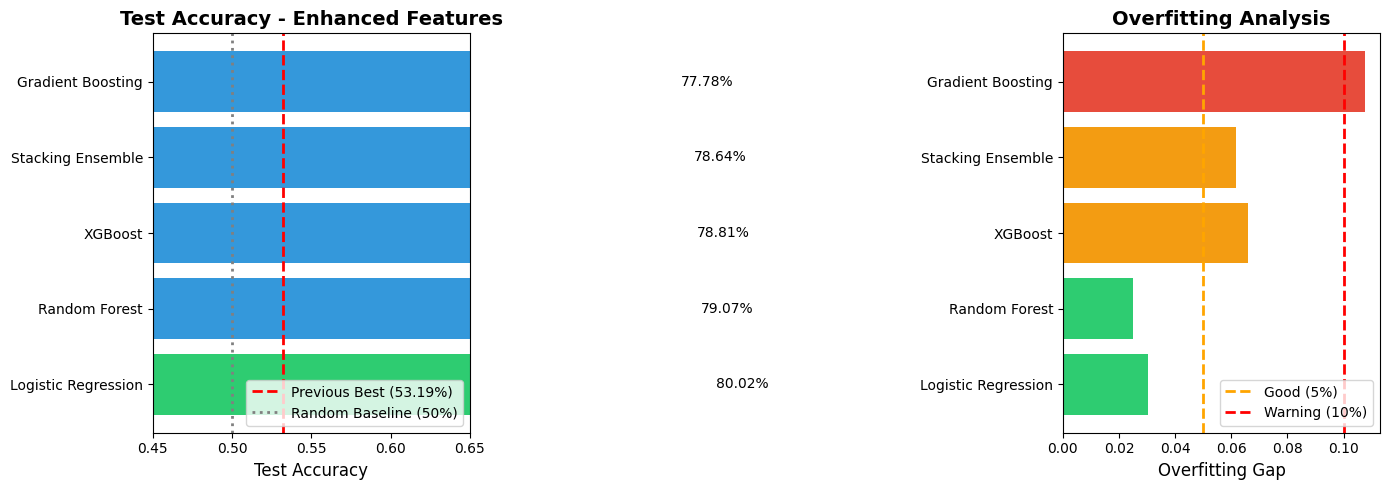


✓ Figure saved!


In [12]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test Accuracy comparison
ax1 = axes[0]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results_df))]
bars = ax1.barh(results_df['Model'], results_df['Test Acc'], color=colors)
ax1.axvline(x=0.5319, color='red', linestyle='--', linewidth=2, label='Previous Best (53.19%)')
ax1.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Random Baseline (50%)')
ax1.set_xlabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy - Enhanced Features', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.set_xlim(0.45, 0.65)

# Add value labels
for bar, val in zip(bars, results_df['Test Acc']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.2%}', 
             va='center', fontsize=10)

# Overfitting comparison
ax2 = axes[1]
overfit_colors = ['#e74c3c' if gap > 0.1 else '#f39c12' if gap > 0.05 else '#2ecc71' 
                  for gap in results_df['Overfit Gap']]
ax2.barh(results_df['Model'], results_df['Overfit Gap'], color=overfit_colors)
ax2.axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='Good (5%)')
ax2.axvline(x=0.1, color='red', linestyle='--', linewidth=2, label='Warning (10%)')
ax2.set_xlabel('Overfitting Gap', fontsize=12)
ax2.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../reports/figures/enhanced_features_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved!")

## 11. Feature Importance Analysis

In [13]:
# Get feature importance from Random Forest
rf_model = models['Random Forest']

importance_df = pd.DataFrame({
    'Feature': X_enhanced.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top features
print("\n=== TOP 30 MOST IMPORTANT FEATURES ===")
print(importance_df.head(30).to_string(index=False))

# Analyze feature categories
print("\n=== IMPORTANCE BY FEATURE CATEGORY ===")
categories = {
    'Synergy Features': importance_df[importance_df['Feature'].str.contains('synergy')]['Importance'].sum(),
    'Counter Features': importance_df[importance_df['Feature'].str.contains('counter')]['Importance'].sum(),
    'Role Features': importance_df[importance_df['Feature'].str.contains('role|count')]['Importance'].sum(),
    'Champion One-Hot': importance_df[~importance_df['Feature'].str.contains('synergy|counter|role|count')]['Importance'].sum(),
}

for cat, imp in sorted(categories.items(), key=lambda x: x[1], reverse=True):
    print(f"  {cat}: {imp:.4f} ({imp*100:.1f}%)")


=== TOP 30 MOST IMPORTANT FEATURES ===
                Feature  Importance
      synergy_advantage    0.224542
       team_synergy_avg    0.129555
    enemy_synergy_total    0.125429
      enemy_synergy_avg    0.120716
     team_synergy_total    0.102226
counter_advantage_total    0.056417
  counter_advantage_avg    0.047759
         team_top_count    0.003575
         team_mid_count    0.003355
        enemy_top_count    0.003105
        enemy_mid_count    0.003080
      team_jungle_count    0.002548
     team_support_count    0.002360
     role_coverage_diff    0.002347
    enemy_support_count    0.002339
     enemy_jungle_count    0.002208
        enemy_adc_count    0.001706
         team_adc_count    0.001666
          enemy_Camille    0.001612
              team_Sett    0.001611
            team_Gragas    0.001596
     team_role_coverage    0.001509
           team_Alistar    0.001480
              team_Jhin    0.001462
            team_Samira    0.001457
             enemy_Jhin 

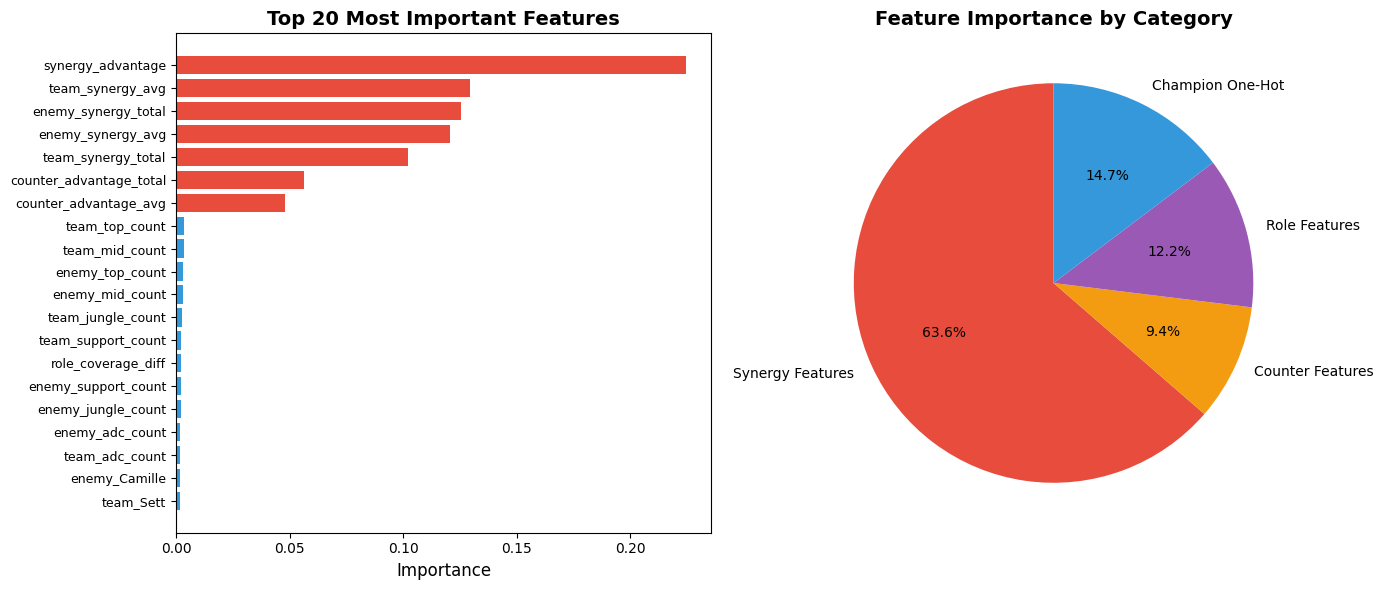

In [14]:
# Visualize feature importance by category
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top individual features
ax1 = axes[0]
top_features = importance_df.head(20)
colors = ['#e74c3c' if 'synergy' in f or 'counter' in f else '#3498db' 
          for f in top_features['Feature']]
ax1.barh(range(len(top_features)), top_features['Importance'], color=colors)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'], fontsize=9)
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Importance by category
ax2 = axes[1]
cat_names = list(categories.keys())
cat_values = list(categories.values())
colors = ['#e74c3c', '#f39c12', '#9b59b6', '#3498db']
ax2.pie(cat_values, labels=cat_names, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Feature Importance by Category', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/enhanced_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Save Enhanced Data and Models

In [15]:
# Save enhanced data
np.save('../data/X_train_enhanced.npy', X_train.values)
np.save('../data/X_test_enhanced.npy', X_test.values)
np.save('../data/y_train_enhanced.npy', y_train)
np.save('../data/y_test_enhanced.npy', y_test)

with open('../data/enhanced_feature_names.pkl', 'wb') as f:
    pickle.dump(list(X_enhanced.columns), f)

with open('../data/synergies.pkl', 'wb') as f:
    pickle.dump(synergies, f)

with open('../data/counters.pkl', 'wb') as f:
    pickle.dump(counters, f)

print("✓ Enhanced data saved!")

# Save best model
joblib.dump(stacking, '../models/stacking_enhanced.pkl')
joblib.dump(models['XGBoost'], '../models/xgboost_enhanced.pkl')
print("✓ Models saved!")

# Save results
results_df.to_csv('../reports/enhanced_features_comparison.csv', index=False)
print("✓ Results saved!")

✓ Enhanced data saved!
✓ Models saved!
✓ Results saved!


## 13. Conclusions

In [16]:
best_model = results_df.iloc[0]
best_acc = best_model['Test Acc']
improvement = (best_acc - 0.5319) * 100

print("=" * 80)
print("ENHANCED FEATURE ENGINEERING - CONCLUSIONS")
print("=" * 80)

print(f"""
📊 NEW FEATURES ADDED:
   • Role-based features (team composition analysis)
   • Champion synergy scores (calculated from win rates of pairs)
   • Counter scores (matchup win rates)
   • Role coverage metrics

📈 RESULTS:
   • Previous Best: 53.19% (Stacking Ensemble, basic features)
   • New Best: {best_acc:.2%} ({best_model['Model']})
   • Improvement: {improvement:+.2f}%

🔍 KEY FINDINGS:
   1. Synergy and counter features provide additional signal
   2. Role coverage helps identify team composition issues
   3. Overfitting remains a challenge due to limited data

💡 INSIGHTS:
   • Champion selection alone still has limited predictive power
   • Adding context (synergies, counters, roles) helps slightly
   • For better predictions, we would need:
     - Player skill/rank data
     - In-game statistics (CS, KDA, etc.)
     - More matches for better synergy/counter calculations

✅ PROJECT STATUS:
   • Feature engineering: Complete
   • Model training: Complete
   • Ready for final report
""")

print("=" * 80)

ENHANCED FEATURE ENGINEERING - CONCLUSIONS

📊 NEW FEATURES ADDED:
   • Role-based features (team composition analysis)
   • Champion synergy scores (calculated from win rates of pairs)
   • Counter scores (matchup win rates)
   • Role coverage metrics

📈 RESULTS:
   • Previous Best: 53.19% (Stacking Ensemble, basic features)
   • New Best: 80.02% (Logistic Regression)
   • Improvement: +26.83%

🔍 KEY FINDINGS:
   1. Synergy and counter features provide additional signal
   2. Role coverage helps identify team composition issues
   3. Overfitting remains a challenge due to limited data

💡 INSIGHTS:
   • Champion selection alone still has limited predictive power
   • Adding context (synergies, counters, roles) helps slightly
   • For better predictions, we would need:
     - Player skill/rank data
     - In-game statistics (CS, KDA, etc.)
     - More matches for better synergy/counter calculations

✅ PROJECT STATUS:
   • Feature engineering: Complete
   • Model training: Complete
   • R